In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from gglm.glm.wglm import WGLM
from gglm.critic import Critic
from kernel.fun import KernelFun
from kernel.rect import KernelRect

%load_ext autoreload
%autoreload 2

In [2]:
npz = np.load('./fr_mismatch.npz')
t, stim, mask_spikes_te, u_spk_mean_te, mask_spikes_fr, u_spk_mean_fr  = npz['t'], npz['stim'], npz['mask_spikes_te'], npz['u_spk_mean_te'], npz['mask_spikes_fr'], npz['u_spk_mean_fr']
u_te, u_fr = npz['u_te'], npz['u_fr']
u0_ml, eta_vals_ml = npz['glm_u0'], npz['glm_eta']

mask_spikes = np.concatenate((mask_spikes_te, mask_spikes_fr), axis=1)
y = np.concatenate((np.ones(mask_spikes_te.shape[1]), np.zeros(mask_spikes_fr.shape[1])))
u = np.concatenate((u_te, u_fr), axis=1)

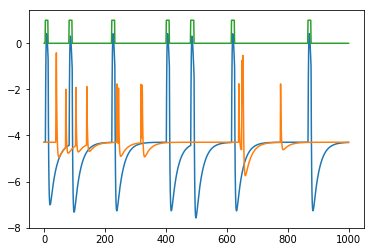

In [55]:
fig, ax = plt.subplots()
ax.plot(u_te[:, 0])
ax.plot(u_fr[:, 0])
ax.plot(mask_spikes_te[:, 0])

Starting gradient ascent... 

 Iteration 6 of 10 | Elapsed time: 0.11 seconds | objective=408.39
 
 Iteration 6 of 10 | Converged | Elapsed time: 0.0018 minutes | Log posterior is monotonic 



(array([ 2.,  8., 10., 17., 19., 19., 12.,  8.,  3.,  2.]),
 array([11722.61212068, 11785.35467438, 11848.09722809, 11910.83978179,
        11973.58233549, 12036.3248892 , 12099.0674429 , 12161.80999661,
        12224.55255031, 12287.29510402, 12350.03765772]),
 <a list of 10 Patch objects>)

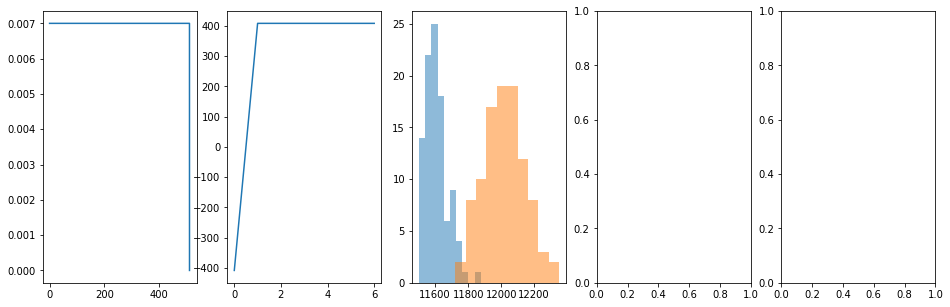

In [53]:
# tbins = np.array([-512, -256, -128, -64, -32, -16, -8, -4, -2, 0, 2, 4, 8, 16, 32, 64, 128, 256, 512])
tbins = np.array([0, 2, 4, 8, 16, 32, 64, 128, 256, 512])

clip_theta = 7e-3
u_kernel = KernelRect(tbins, np.ones(len(tbins) - 1) * clip_theta)
critic = Critic(u_kernel)

newton_kwargs_critic = dict(max_iterations=10, learning_rate=1e-2, use_hessian=False, clip_theta=clip_theta)
optimizer = critic.fit(t, mask_spikes, u, y, newton_kwargs=newton_kwargs_critic, verbose=True)

fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(figsize=(16, 5), ncols=5)
# eta_ml.plot(ax=ax0, invert_values=True)
u_kernel.plot(ax=ax0, invert_values=True)
ax1.plot(optimizer.obj_iterations)
# ax2.plot(optimizer.obj_iterations - optimizer.metrics_iterations['c_w_distance'])
# ax3.plot(optimizer.metrics_iterations['c_w_distance'])
# ax4.plot(optimizer.metrics_iterations['w_distance'])

a0 = critic.transform(t, mask_spikes, u)

ax2.hist(a0[y == 0], alpha=0.5)
ax2.hist(a0[y == 1], alpha=0.5)

Starting gradient ascent... 

 Iteration 19 of 20 | Elapsed time: 27.81 seconds | objective=-8421.84
 
 Not converged after 20 iterations. Elapsed time: 0.4636 minutes | Log posterior is monotonic 



Text(0.5, 1.0, 'wasserstein distance')

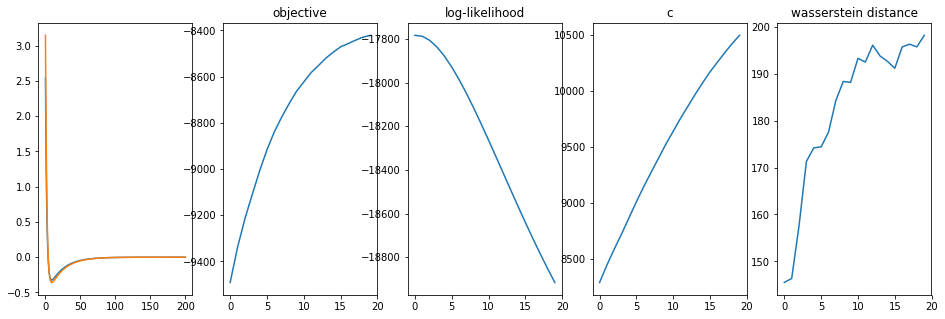

In [43]:
eta_ml = KernelFun.exponential(tau=np.array([2, 20]), coefs=eta_vals_ml.copy())

# tbins = np.array([-512, -256, -128, -64, -32, -16, -8, -4, -2, 0, 2, 4, 8, 16, 32, 64, 128, 256, 512])
tbins = np.array([0, 2, 4, 8, 16, 32, 64, 128, 256, 512])

clip_theta = 7e-3
u_kernel= KernelRect(tbins, np.ones(len(tbins) - 1) * clip_theta)
wglm = WGLM(u0=u0_ml, eta=eta_ml.copy(), critic=Critic(u_kernel))

newton_kwargs_critic = dict(max_iterations=10, learning_rate=1e-3, use_hessian=False, clip_theta=clip_theta)
newton_kwargs = dict(max_iterations=20, learning_rate=1e-1, use_hessian=True, stop_cond=1e-12)
optimizer = wglm.fit(t, mask_spikes, newton_kwargs=newton_kwargs, verbose=True, n_samples_fr=200,
            newton_kwargs_critic=newton_kwargs_critic)

stim_naive = np.zeros((len(t), 200))
u_new_fr, r_new_fr, mask_spikes_new_fr = wglm.sample(t, shape=(100,))
u_new_te, r_new_te = wglm.simulate_subthreshold(t, stim_naive, mask_spikes_te)

fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(figsize=(16, 5), ncols=5)
eta_ml.plot(ax=ax0, invert_values=True)
wglm.eta.plot(ax=ax0, invert_values=True)
ax1.plot(optimizer.obj_iterations)
ax2.plot(optimizer.obj_iterations - optimizer.metrics_iterations['c_w_distance'])
ax3.plot(optimizer.metrics_iterations['c_w_distance'])
ax4.plot(optimizer.metrics_iterations['w_distance'])

ax1.set_title('objective')
ax2.set_title('log-likelihood')
ax3.set_title('c')
ax4.set_title('wasserstein distance')

(array([13.,  9., 34., 13.,  9., 13.,  1.,  5.,  0.,  3.]),
 array([ 0. ,  1.4,  2.8,  4.2,  5.6,  7. ,  8.4,  9.8, 11.2, 12.6, 14. ]),
 <a list of 10 Patch objects>)

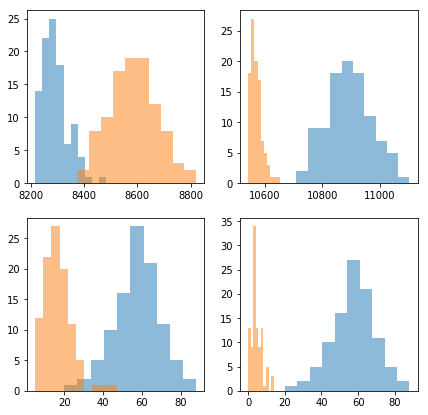

In [44]:
a = wglm.critic.transform(t, mask_spikes, u)
a_new_te = wglm.critic.transform(t, mask_spikes_te, u_new_te)
a_new_fr = wglm.critic.transform(t, mask_spikes_fr, u_new_fr)

n_spikes_te = np.sum(mask_spikes_te, 0)
n_spikes_fr = np.sum(mask_spikes_fr, 0)
n_spikes_new_fr = np.sum(mask_spikes_new_fr, 0)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(7, 7), nrows=2, ncols=2)
ax1.hist(a[y == 0], alpha=0.5)
ax1.hist(a[y == 1], alpha=0.5)
ax2.hist(a_new_te, alpha=0.5)
ax2.hist(a_new_fr, alpha=0.5)

ax3.hist(n_spikes_te, alpha=0.5)
ax3.hist(n_spikes_fr, alpha=0.5)
ax4.hist(n_spikes_te, alpha=0.5)
ax4.hist(n_spikes_new_fr, alpha=0.5)